In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# !pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
__file__ = 'baseline-EfficientNet-B4'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time
import efficientnet.keras as efn 

Using TensorFlow backend.


In [5]:
path_data = '../garbage_classify/train_data'
batch_size = 16
img_size = 380
img_width = img_size
img_height = img_size
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

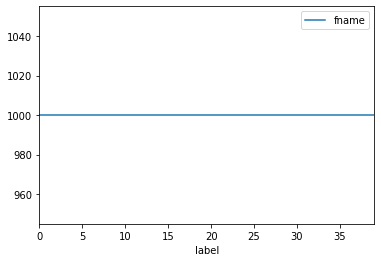

In [6]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [7]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [8]:
ig = ImageDataGenerator(preprocessing_function=efn.preprocess_input)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 40000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [9]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3),pooling='avg')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
len(base_model.layers)

468

In [11]:
for layer in base_model.layers[:100]:
    layer.trainable=False

In [12]:
x = base_model.output

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x=Dropout(0.3)(x)

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}
predictions = Dense(n_classess, activation='softmax',kernel_initializer=DENSE_KERNEL_INITIALIZER)(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 380, 380, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [13]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [14]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc',verbose=1)

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=1e-6,verbose=1)

csv_logger = CSVLogger(f'../tmp/training_{__file__}.log',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop,reduce_lr,csv_logger],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2500/2500 [==============================] - 1124s 450ms/step - loss: 1.2669 - acc: 0.7001 - val_loss: 0.4161 - val_acc: 0.8995

Epoch 00001: val_acc improved from -inf to 0.89953, saving model to ../tmp/ckpt-baseline-EfficientNet-B4-Epoch_001-acc_0.70012-val_acc_0.89953.h5
Epoch 2/100
2500/2500 [==============================] - 1101s 440ms/step - loss: 0.4440 - acc: 0.8920 - val_loss: 0.3340 - val_acc: 0.9058

Epoch 00002: val_acc improved from 0.89953 to 0.90581, saving model to ../tmp/ckpt-baseline-EfficientNet-B4-Epoch_002-acc_0.89195-val_acc_0.90581.h5
Epoch 3/100
2500/2500 [==============================] - 1101s 440ms/step - loss: 0.2463 - acc: 0.9369 - val_loss: 0.3398 - val_acc: 0.9085

Epoch 00003: val_acc improved from 0.90581 to 0.90851, saving model to ../tmp/ckpt-baseline-EfficientNet-B4-Epoch_003-acc_0.93695-val_acc_0.90851.h5
Epoch 4/100
2500/2500 [==============================] - 1102s 441ms/step - loss: 0.1

In [ ]:
!ls